# San Diego Airbnb Listings Analysis

#### A comprehensive analysis of San Diego Airbnb listings from 2019 to uncover patterns and insights about rental prices, host activities, and neighborhood trends.

## Context

Airbnb has transformed how people travel and stay, offering diverse accommodation options across the globe. San Diego, with its vibrant culture and scenic beauty, attracts millions of visitors each year. This project utilizes a dataset containing Airbnb listings from August 2019 in San Diego. The analysis focuses on understanding the factors influencing rental prices, identifying popular neighborhoods, and exploring host behavior. By examining data such as property types, location, prices, and reviews, the project aims to provide valuable insights for both potential hosts and travelers interested in the San Diego area.

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score, classification_report
from pandas.api.types import is_numeric_dtype, is_datetime64_dtype
sns.set_theme()
%matplotlib inline
pd.options.display.max_columns = 100
pd.options.display.max_rows = 100

## Loading Data

Dataset: San Diego Airbnb Listings, 2019 (https://www.kaggle.com/datasets/thedevastator/san-diego-airbnb-listings-august-2019)


In [2]:
# load the dataset
df = pd.read_csv('Dataset/listings.csv')

/var/folders/_k/8vc6fgyj6v186p_cjyk5fpyw0000gn/T/ipykernel_5131/3511573793.py:2: DtypeWarning: Columns (1,13,14,25,44,55,57) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('Dataset/listings.csv')


In [3]:
# Shape of the dataframe
print("Number of Instances:",df.shape[0])
print("Number of Features:",df.shape[1])

Number of Instances: 13052
Number of Features: 76


In [4]:
# Create a list for the numeric and categorical variable names
numeric_column_names = []
cat_column_names = []
# Create a list for the columns that need to be converted to numeric
numeric_columns = ['accommodates', 'host_response_rate', 'host_listings_count', 'nightly_price', 'price_per_stay', 'security_deposit','cleaning_fee', 'guests_included', 'extra_people', 'minimum_nights']

# Remove non-numeric characters from the observations in the specified columns (keeps decimal point)
# Code was found online and modified by ChatGPT
for col in numeric_columns:
  df[col] = df[col].map(lambda i: ''.join([x for x in str(i) if x.isdigit() or x == '.']) if isinstance(i, str) else str(i))

# convert the specified columns to numeric data type
def convert_to_numeric(col):
  if col.name in numeric_columns:
    return pd.to_numeric(col, errors='coerce')
  else:
    return col
df = df.apply(convert_to_numeric)

# convert the date-time variables to appropriate data type
date_columns = ['host_since', 'first_review', 'last_review']
for col in date_columns:
  df[col] = pd.to_datetime(df[col], errors='coerce')

# populate the numeric_column_names list with numeric and date-time variable names
# populate the cat_column_names list with categorical variable names
types = df.dtypes.tolist()
for i in range(len(df.columns)):
  if is_numeric_dtype(types[i]) or is_datetime64_dtype(types[i]):
    numeric_column_names.append(df.columns[i])
  else:
    cat_column_names.append(df.columns[i])

/var/folders/_k/8vc6fgyj6v186p_cjyk5fpyw0000gn/T/ipykernel_5131/513940026.py:23: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col], errors='coerce')
/var/folders/_k/8vc6fgyj6v186p_cjyk5fpyw0000gn/T/ipykernel_5131/513940026.py:23: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col], errors='coerce')
/var/folders/_k/8vc6fgyj6v186p_cjyk5fpyw0000gn/T/ipykernel_5131/513940026.py:23: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col], errors='coerce')


In [5]:
# look at the numeric variables
df.head().loc[:,numeric_column_names]

,index,host_since,host_response_rate,host_acceptance_rate,host_listings_count,host_total_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,beds,square_feet,nightly_price,price_per_stay,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,number_of_reviews,number_of_stays,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value
0,0,2019-03-18,100.0,NaN,1.0,1.0,32.91736,-117.07635,1.0,1.0,1.0,1.0,NaN,1100.0,1100.0,1000.0,0.0,1.0,0.0,60.0,90.0,0.0,0.0,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2016-06-24,NaN,NaN,1.0,1.0,32.84067,-117.27443,1.0,2.0,2.0,3.0,NaN,1400.0,1400.0,NaN,NaN,1.0,0.0,30.0,1125.0,2.0,4.0,2017-04-22,2017-08-31,100.0,10.0,10.0,10.0,10.0,10.0,10.0
2,2,2017-11-22,NaN,NaN,1.0,1.0,32.79797,-117.24250,1.0,1.0,1.0,1.0,NaN,1250.0,1250.0,NaN,NaN,1.0,0.0,30.0,30.0,0.0,0.0,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,2018-04-22,NaN,NaN,1.0,1.0,32.77545,-117.05923,1.0,1.0,1.0,1.0,NaN,1150.0,1150.0,NaN,NaN,1.0,0.0,31.0,40.0,0.0,0.0,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,2012-09-21,67.0,NaN,6.0,6.0,32.84619,-117.27558,1.0,1.0,1.0,1.0,NaN,110.0,110.0,200.0,NaN,1.0,50.0,180.0,365.0,2.0,4.0,2015-02-22,2018-09-23,90.0,7.0,7.0,8.0,8.0,9.0,10.0


In [6]:
# look at the categorical variables
df.head(2).loc[:,cat_column_names]

,id,listing_url,name,summary,space,description,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,host_id,host_url,host_name,host_location,host_about,host_response_time,host_is_superhost,host_neighbourhood,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,city,state,zipcode,market,smart_location,country_code,country,is_location_exact,property_type,room_type,bed_type,amenities,requires_license,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification
0,33159143,https://www.airbnb.com/rooms/33159143,"PRIVATE ROOM, SAFE NEIGHBORHOOD IN SCRIPPS RANCH",80% of the house + yourCozy room ... in Scripp...,"Full bed, private bath...",80% of the house + yourCozy room ... in Scripp...,The neighborhood is a typical Southern Califor...,Have alarm system if you choose to use... I wi...,You can park in the drive way or plenty of spa...,"Kitchen, Dining room, Living room, Very Comfor...","I lived in San Diego 40+ years, love to share ...",#NAME?,NaN,249661563,https://www.airbnb.com/users/show/249661563,Robert,"San Diego, California, United States",Retired businessman of 30 years in this commun...,within a few hours,f,Scripps Ranch,t,f,"San Diego, CA, United States",Scripps Ranch,Scripps Ranch,San Diego,CA,92131,San Diego,"San Diego, CA",US,United States,t,House,Private room,Real Bed,"{Wifi,Kitchen,""Free parking on premises"",Heati...",f,t,f,strict_14_with_grace_period,f,f
1,17138468,https://www.airbnb.com/rooms/17138468,NOT AVAILABLE,AVAILABLE ONLY IN WINTER PRIME La Jolla Villag...,NaN,AVAILABLE ONLY IN WINTER PRIME La Jolla Villag...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,79755951,https://www.airbnb.com/users/show/79755951,Juan Carlos,"San Diego, California, United States",Quiet and considerate.,NaN,f,La Jolla,t,f,"San Diego, CA, United States",La Jolla,La Jolla,San Diego,CA,92037,San Diego,"San Diego, CA",US,United States,t,Apartment,Entire home/apt,Real Bed,"{TV,Wifi,""Air conditioning"",Kitchen,""Free park...",f,t,f,strict_14_with_grace_period,f,f


In [7]:
def remove_outliers(df, columns, threshold=4.5):
    """
    Remove outliers from the specified columns of a DataFrame using the IQR method.
    """
    cleaned_df = df.copy()
    outliers_df = pd.DataFrame()  # DataFrame to store outlier rows
    for col in columns:
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - threshold * iqr
        upper_bound = q3 + threshold * iqr
        outliers = cleaned_df[(cleaned_df[col] < lower_bound) | (cleaned_df[col] > upper_bound)]
        outliers_df = pd.concat([outliers_df, outliers])  # Concatenate outlier rows
        cleaned_df = cleaned_df[(cleaned_df[col] >= lower_bound) & (cleaned_df[col] <= upper_bound)]

    return cleaned_df, outliers_df

# Remove outliers from specified columns
df, outliers_df = remove_outliers(df, ['nightly_price'])


In [8]:
df = df.dropna(subset=['amenities'])
# Extract individual phrases from the 'amenities' column
df['amenities'] = df['amenities'].str.strip('{}').str.replace('"', '').str.split(',')

# Create a set to store unique phrases
unique_phrases = set()

# Extract unique phrases
for item in df['amenities']:
    unique_phrases.update(item)

# Create a DataFrame with binary values for each unique phrase
new_columns = {phrase: df['amenities'].apply(lambda x: 1 if phrase in x else 0) for phrase in unique_phrases}
new_df = pd.concat(new_columns.values(), axis=1, keys=new_columns.keys())
df = pd.concat([df, new_df], axis=1)

In [9]:
predictors = []
for col in df.columns:
  if df.loc[:, col].isna().sum() / df.shape[0] < .15 : # Only consider columns with less than 15% missing values
    predictors.append(col)

df = df.dropna(subset=['nightly_price', 'cleaning_fee'])
df.loc[:, 'total_price'] = (df['nightly_price'] + df['cleaning_fee']).copy() # Create a new column for total price

elements_to_remove = ['index', 'id', 'listing_url', 'name', 'summary', 'description', 'host_id', 'host_name', 'host_url',
                      'host_since', 'neighbourhood', 'state', 'is_location_exact', 'country', 'country_code', 'street', 'smart_location',
                      'nightly_price', 'cleaning_fee', 'market', 'requires_license', 'amenities', 'price_per_stay', 'minimum_nights',
                      'first_review', 'last_review', 'total_price']

predictors = [x for x in predictors if x not in elements_to_remove]

cleansed_df = df.copy()

variables_to_encode = ['host_location', 'host_is_superhost', 'host_neighbourhood', 'host_has_profile_pic', 'host_identity_verified',
                       'neighbourhood_cleansed', 'property_type', 'room_type', 'bed_type', 'instant_bookable', 'is_business_travel_ready',
                       'cancellation_policy', 'require_guest_profile_picture', 'require_guest_phone_verification', 'city', 'zipcode']

cleansed_df = cleansed_df.dropna(subset=predictors)
label_encoder = LabelEncoder()

for col in variables_to_encode:
    cleansed_df.loc[:, col] = label_encoder.fit_transform(cleansed_df[col])

target = 'total_price' # set 'target'
print('Number of rows used for feature selection:', cleansed_df.shape[0])


Number of rows used for feature selection: 9636


In [10]:
# Calculate the median nightly rate for each neighborhood
neighbourhood_avg_rate = df.groupby('neighbourhood_cleansed')['nightly_price'].transform('median')

# Append the calculated median nightly rate as a new column
df['neighbourhood_median_nightly'] = neighbourhood_avg_rate
cleansed_df['neighbourhood_median_nightly'] = neighbourhood_avg_rate

# Calculate the median nightly rate for each property type
property_avg_rate = df.groupby('property_type')['nightly_price'].transform('median')

# Append the calculated average nightly rate as a new column
df['property_median_nightly'] = property_avg_rate
cleansed_df['property_median_nightly'] = property_avg_rate

predictors = predictors + ['neighbourhood_median_nightly', 'property_median_nightly']

In [11]:
print('Predictors considered for Sequential Feature Selection:\n')
cleansed_df[predictors].dtypes

Predictors considered for Sequential Feature Selection:



host_location                    object
host_is_superhost                object
host_neighbourhood               object
host_listings_count             float64
host_total_listings_count       float64
                                 ...   
Outdoor kitchen                   int64
Bed linens                        int64
Lake access                       int64
neighbourhood_median_nightly    float64
property_median_nightly         float64
Length: 220, dtype: object

In [12]:
print(len(predictors))

220


In [13]:
columns_subset = predictors.copy()
columns_subset.append('total_price')

# Calculate correlation matrix
subset_correlation = cleansed_df[columns_subset].corr()

# Get correlation with 'total_price' and sort
correlation_with_variable = subset_correlation['total_price']
df_correlation_with_variable = pd.DataFrame(correlation_with_variable)
print(df_correlation_with_variable.sort_values(by = 'total_price', ascending = False))

                          total_price
total_price                  1.000000
accommodates                 0.732958
bedrooms                     0.724538
beds                         0.664263
bathrooms                    0.660278
...                               ...
longitude                   -0.380595
room_type                   -0.424307
is_business_travel_ready          NaN
Stand alone steam shower          NaN
10.0                              NaN

[221 rows x 1 columns]


In [14]:
from mlxtend.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LinearRegression

X = cleansed_df[predictors]
y = cleansed_df[target]

# Perform stepwise regression
sfs = SequentialFeatureSelector(
    estimator=LinearRegression(),    # Using Linear Regression estimator
    k_features=6,                     # Number of features to select
    forward=True,                    # Whether to perform forward selection
    scoring='r2',                    # Scoring metric for regression
    cv=None
)

# Fit the SequentialFeatureSelector data
selected_features = sfs.fit(X, y)

# get the selected features and their indices
print("Selected features:", selected_features.k_feature_names_)

Selected features: ('room_type', 'accommodates', 'bathrooms', 'bedrooms', 'number_of_stays', 'neighbourhood_median_nightly')


In [15]:
from mlxtend.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LinearRegression

X = cleansed_df[predictors]
y = cleansed_df[target]

# Perform stepwise regression
sfs = SequentialFeatureSelector(
    estimator=LinearRegression(),    # Using Linear Regression estimator
    k_features=10,                     # Number of features to select
    forward=True,                    # Whether to perform forward selection
    scoring='r2',                    # Scoring metric for regression
    cv=None
)

# Fit the SequentialFeatureSelector data
selected_features = sfs.fit(X, y)

# get the selected features and their indices
print("Selected features:", selected_features.k_feature_names_)

Selected features: ('city', 'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'number_of_stays', 'cancellation_policy', 'Cable TV', 'Hot water', 'neighbourhood_median_nightly')


In [16]:
labeled_df = df.copy() # We will use the full dataset and only drop NA rows for our selected predictors
for col in variables_to_encode:
  labeled_df[col] = label_encoder.fit_transform(labeled_df[col])

def regression_models(predictors):
  df_for_predictors = labeled_df.copy()
  df_for_predictors = df_for_predictors.dropna(subset=predictors)
  print('Predictors: ', predictors)
  print('Number of rows: ', df_for_predictors.shape[0])
  X = df_for_predictors[predictors]
  y = df_for_predictors[target]

  # Split the dataset into training and testing sets
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

  def adj_r2(r2_val):
    # calculate number of predictors for Adjusted R-squared
    num_predictors = len(predictors)
    # calculate sample size for Adjusted R-squared
    sample_size = y_test.shape[0]
    return 1-(1-r2_val)*(sample_size-1)/(sample_size-num_predictors-1)

  def cross_validation(model):
    # Initialize KFold -- shuffle (randomize) the rows
    kfold = KFold(shuffle=True, random_state=42)

    # Perform stratified cross-validation
    scores = cross_val_score(model, X, y, cv=kfold)
    print()
    print("Cross Validation Scores:", scores)

    # Calculate and print the mean and standard deviation
    print("Cross Validation Score Mean:", scores.mean())
    print("Cross Validation Score Standard deviation:", scores.std())

  def calculate_rmse(y_actual, y_pred):
    mse = mean_squared_error(y_actual, y_pred)
    rmse = np.sqrt(mse)
    return rmse

  # Linear Regression
  lr_model = LinearRegression().fit(X_train, y_train)

  # Predict the labels for the test set
  lr_predictions = lr_model.predict(X_test)

  # Calculate R-squared
  lr_r_squared = r2_score(y_test, lr_predictions)
  print('\nLinear Regression')
  print("R-squared:", lr_r_squared)
  print("Adjusted R-squared:", adj_r2(lr_r_squared))
  print("RMSE:", calculate_rmse(y_test, lr_predictions))

  cross_validation(LinearRegression().fit(X, y))

  # Random Forest
  rf_model = RandomForestRegressor().fit(X_train, y_train)

  # Predict the labels for the test set
  rf_predictions = rf_model.predict(X_test)

  # Calculate R-squared
  rf_r_squared = r2_score(y_test, rf_predictions)
  print('\nRandom Forest')
  print("R-squared:", rf_r_squared)
  print("Adjusted R-squared:", adj_r2(rf_r_squared))
  print("RMSE:", calculate_rmse(y_test, rf_predictions))

  cross_validation(RandomForestRegressor().fit(X, y))

  # XGBoost
  xgb_model = xgb_regressor = xgb.XGBRegressor().fit(X_train, y_train)

  # Predict the labels for the test set
  xgb_predictions = xgb_model.predict(X_test)

  # Calculate R-squared
  xgb_r_squared = r2_score(y_test, xgb_predictions)
  print('\nXG Boost')
  print("R-squared:", xgb_r_squared)
  print("Adjusted R-squared:", adj_r2(xgb_r_squared))
  print("RMSE:", calculate_rmse(y_test, xgb_predictions))

  cross_validation(xgb.XGBRegressor().fit(X, y))

  # Residuals vs. Fitted Values Plot
  plt.figure();
  fig, axs = plt.subplots(1,3, figsize=(30,10))

  predictions = [lr_predictions, rf_predictions, xgb_predictions]
  labels = ["Linear Regression", "Random Forest", "XGBoost"]

  for i, prediction in enumerate(predictions):
      # Calculate residuals
      residuals = y_test - prediction

      # Plot residuals on the corresponding subplot
      axs[i].scatter(prediction, residuals, alpha=0.5)
      axs[i].set_xlabel('Predicted Values')
      axs[i].set_ylabel('Residuals')
      axs[i].set_title('Residual Plot: ' + labels[i])
      axs[i].axhline(y=0, color='r', linestyle='--')  # Add a horizontal line at y=0 for reference


  # Show the plot
  plt.show()

Predictors:  ['longitude', 'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'cancellation_policy']
Number of rows:  11289

Linear Regression
R-squared: 0.6765250507826963
Adjusted R-squared: 0.6759508348965118
RMSE: 134.13448059038316

Cross Validation Scores: [0.66023209 0.69385797 0.68016264 0.72361956 0.67058412]
Cross Validation Score Mean: 0.6856912735109572
Cross Validation Score Standard deviation: 0.02196456987275475

Random Forest
R-squared: 0.716515123647885
Adjusted R-squared: 0.7160118960567274
RMSE: 125.5697566274729

Cross Validation Scores: [0.71377948 0.71722529 0.69805705 0.7369252  0.68954915]
Cross Validation Score Mean: 0.711107234522582
Cross Validation Score Standard deviation: 0.016408518252604868

XG Boost
R-squared: 0.73029978356313
Adjusted R-squared: 0.7298210257824728
RMSE: 122.47875206531938

Cross Validation Scores: [0.72883663 0.73335559 0.72920922 0.75377971 0.70374294]
Cross Validation Score Mean: 0.7297848181083123
Cross Validation Score Standard 

<Figure size 640x480 with 0 Axes>

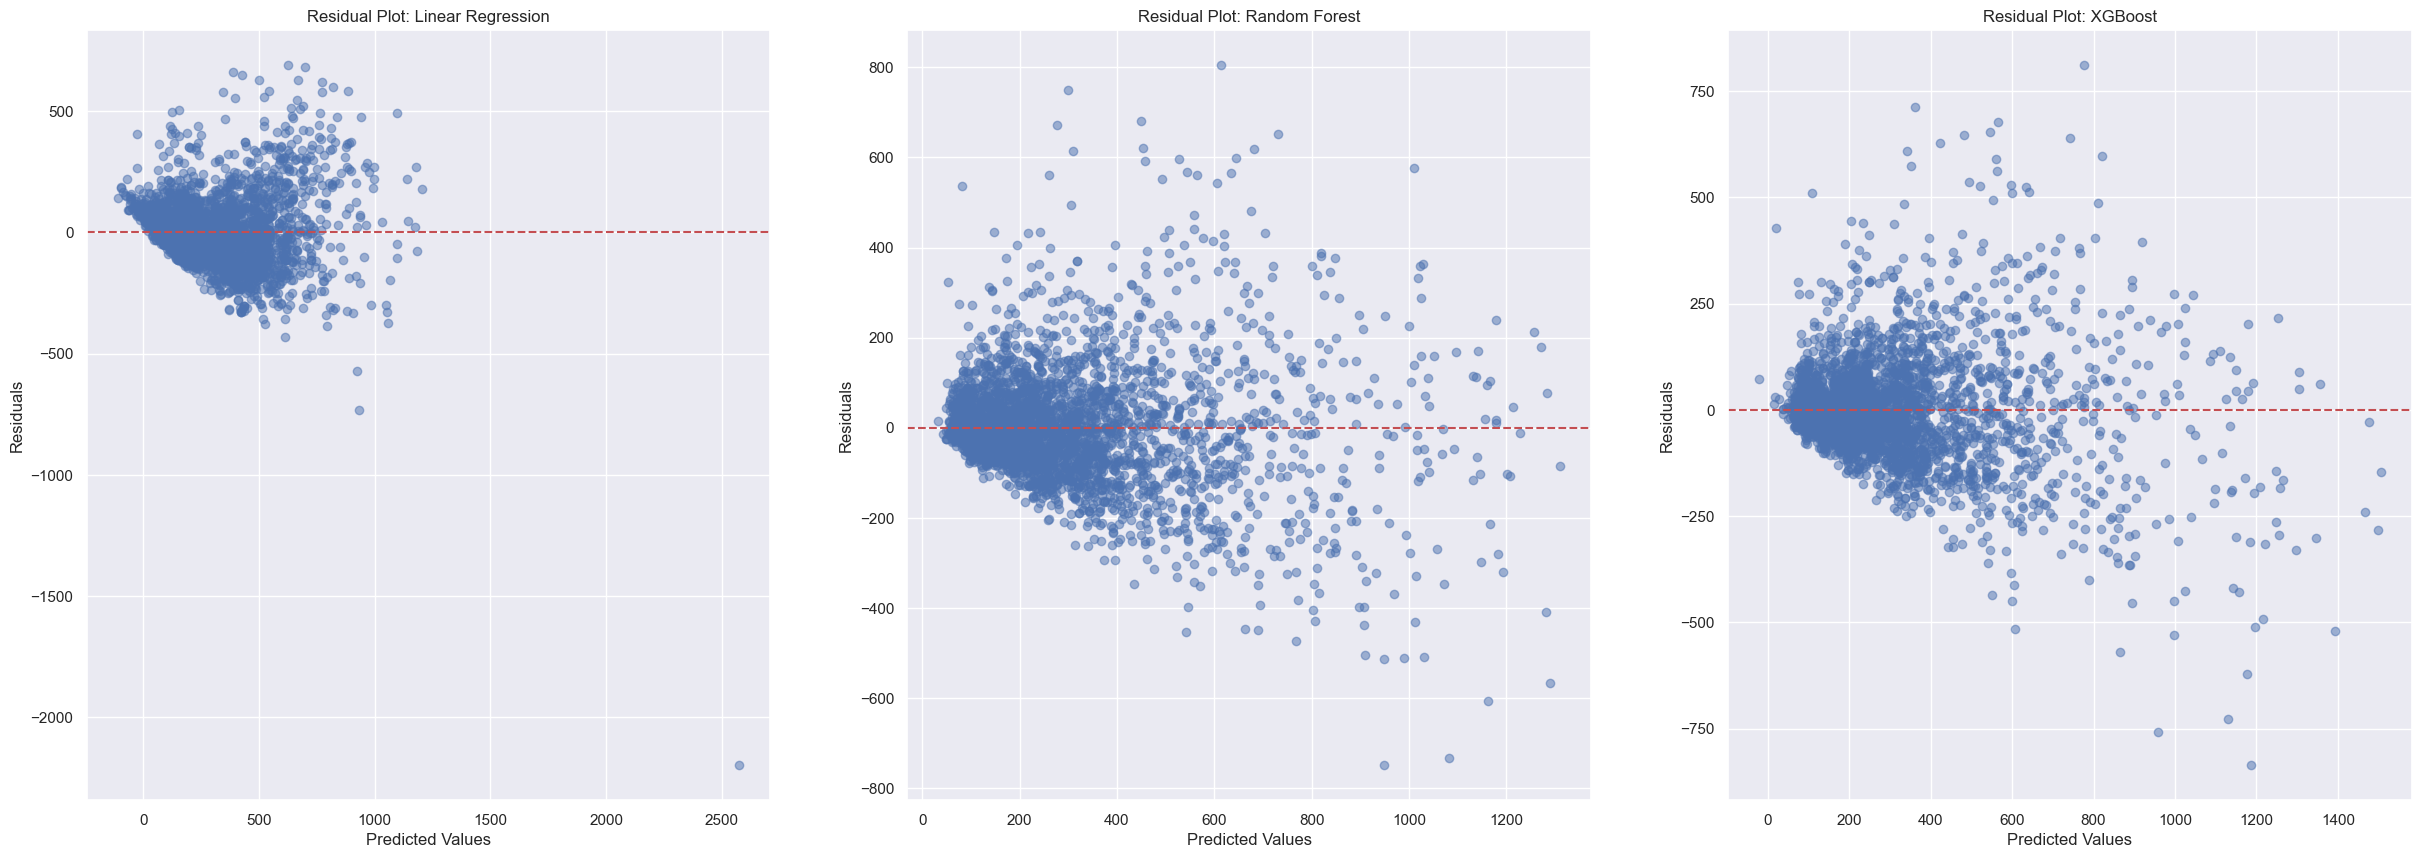

In [17]:
predictors = ['longitude', 'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'cancellation_policy']
regression_models(predictors)

Predictors:  ['neighbourhood_cleansed', 'longitude', 'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'cancellation_policy']
Number of rows:  11289

Linear Regression
R-squared: 0.6775539529610834
Adjusted R-squared: 0.676885967660914
RMSE: 133.9209846453186

Cross Validation Scores: [0.66175851 0.695309   0.68143738 0.72387368 0.67272008]
Cross Validation Score Mean: 0.6870197288861041
Cross Validation Score Standard deviation: 0.021450862382329253

Random Forest
R-squared: 0.7400068365434251
Adjusted R-squared: 0.7394682298123816
RMSE: 120.25442591092724

Cross Validation Scores: [0.73575017 0.72780485 0.71901482 0.75840504 0.71474553]
Cross Validation Score Mean: 0.7311440823896291
Cross Validation Score Standard deviation: 0.015437344681960003

XG Boost
R-squared: 0.7521496162634701
Adjusted R-squared: 0.7516361647434477
RMSE: 117.41265347317855

Cross Validation Scores: [0.7418428  0.73946088 0.73523836 0.76527085 0.72713974]
Cross Validation Score Mean: 0.7417905250787368
Cr

<Figure size 640x480 with 0 Axes>

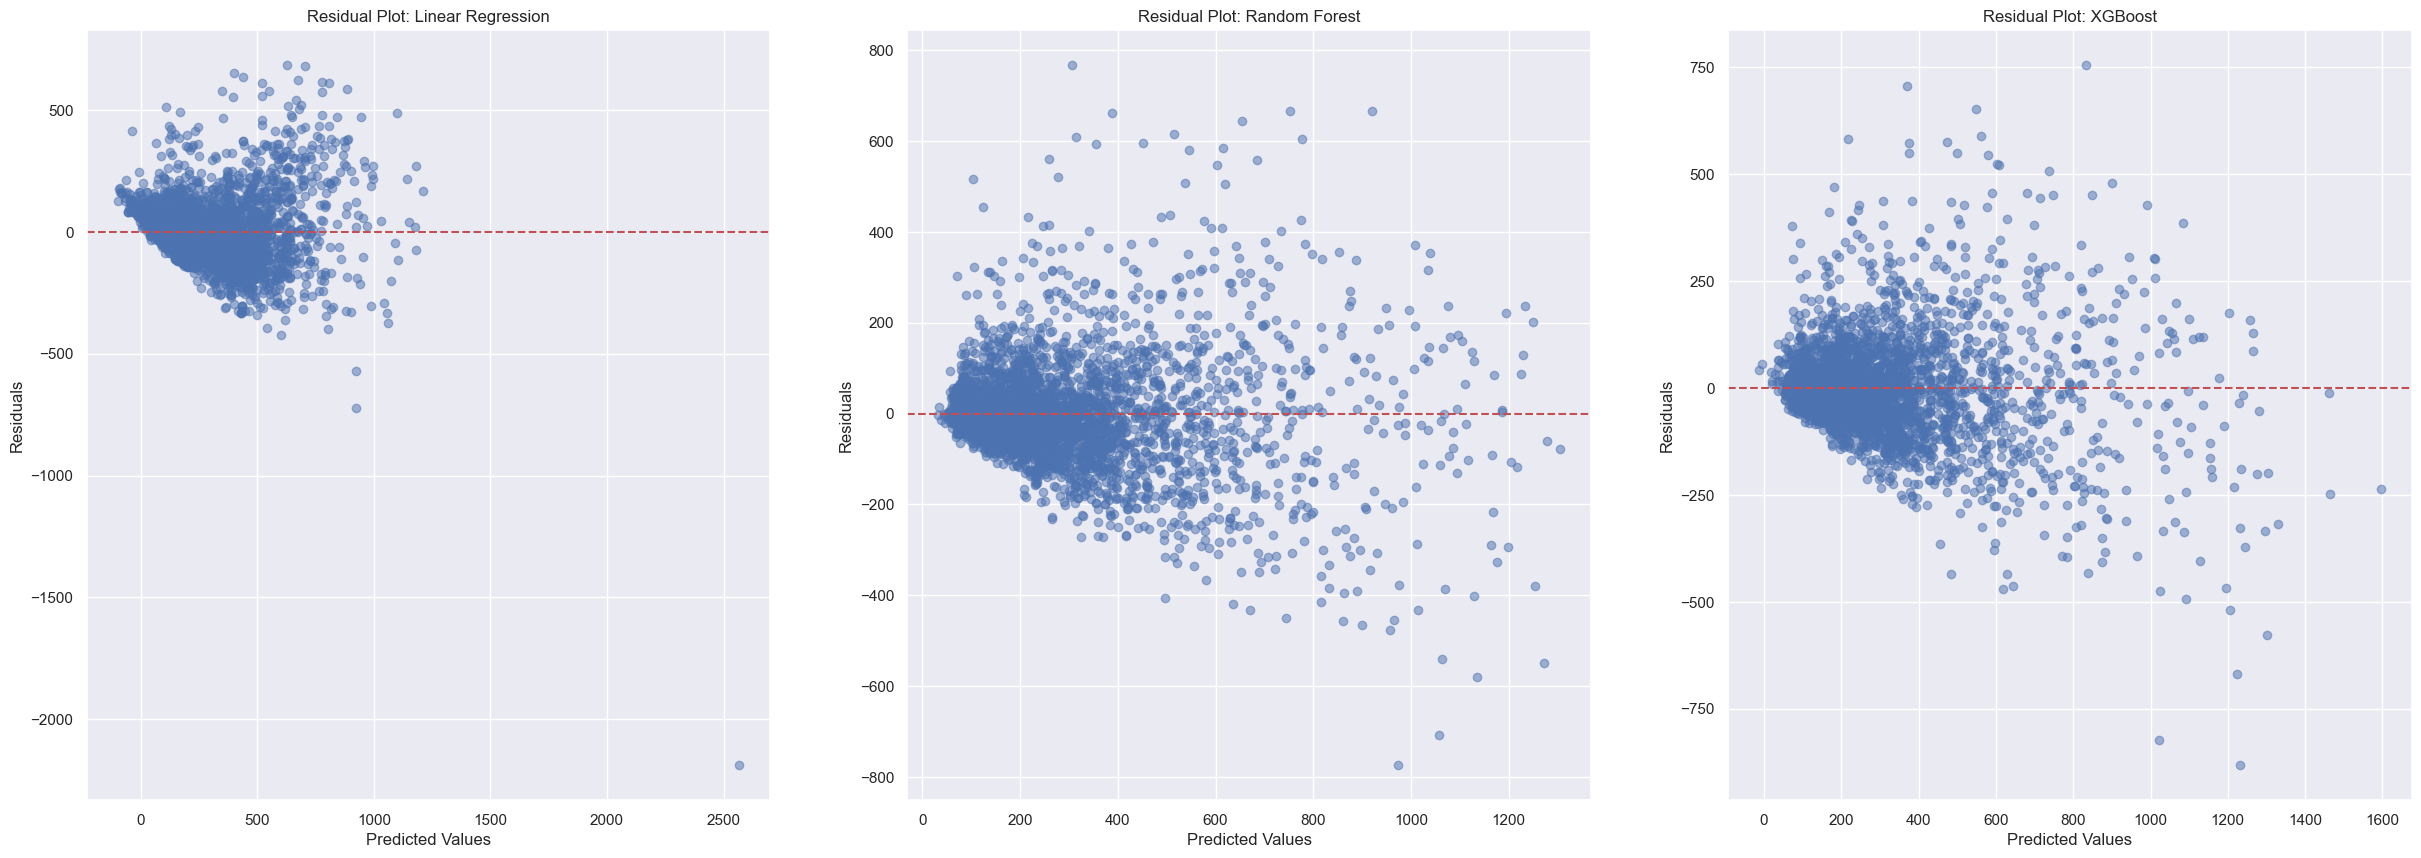

In [18]:
predictors = ['neighbourhood_cleansed', 'longitude', 'room_type', 'accommodates',
              'bathrooms', 'bedrooms', 'cancellation_policy']
regression_models(predictors)

Predictors:  ['room_type', 'accommodates', 'bathrooms', 'bedrooms', 'number_of_reviews', 'neighbourhood_median_nightly']
Number of rows:  11289

Linear Regression
R-squared: 0.6838887601872805
Adjusted R-squared: 0.6833276159745951
RMSE: 132.59894669808807

Cross Validation Scores: [0.66779528 0.70656556 0.69048546 0.73040714 0.68382821]
Cross Validation Score Mean: 0.6958163296728038
Cross Validation Score Standard deviation: 0.021304378297786437

Random Forest
R-squared: 0.7083910687743946
Adjusted R-squared: 0.7078734197840533
RMSE: 127.35632418797668

Cross Validation Scores: [0.71693712 0.69532401 0.72262819 0.74958993 0.68973752]
Cross Validation Score Mean: 0.714843354876946
Cross Validation Score Standard deviation: 0.021371099045261716

XG Boost
R-squared: 0.7400899898263664
Adjusted R-squared: 0.7396286111100818
RMSE: 120.23519396299156

Cross Validation Scores: [0.73631387 0.73507648 0.73566039 0.76451819 0.72558694]
Cross Validation Score Mean: 0.7394311738824948
Cross Vali

<Figure size 640x480 with 0 Axes>

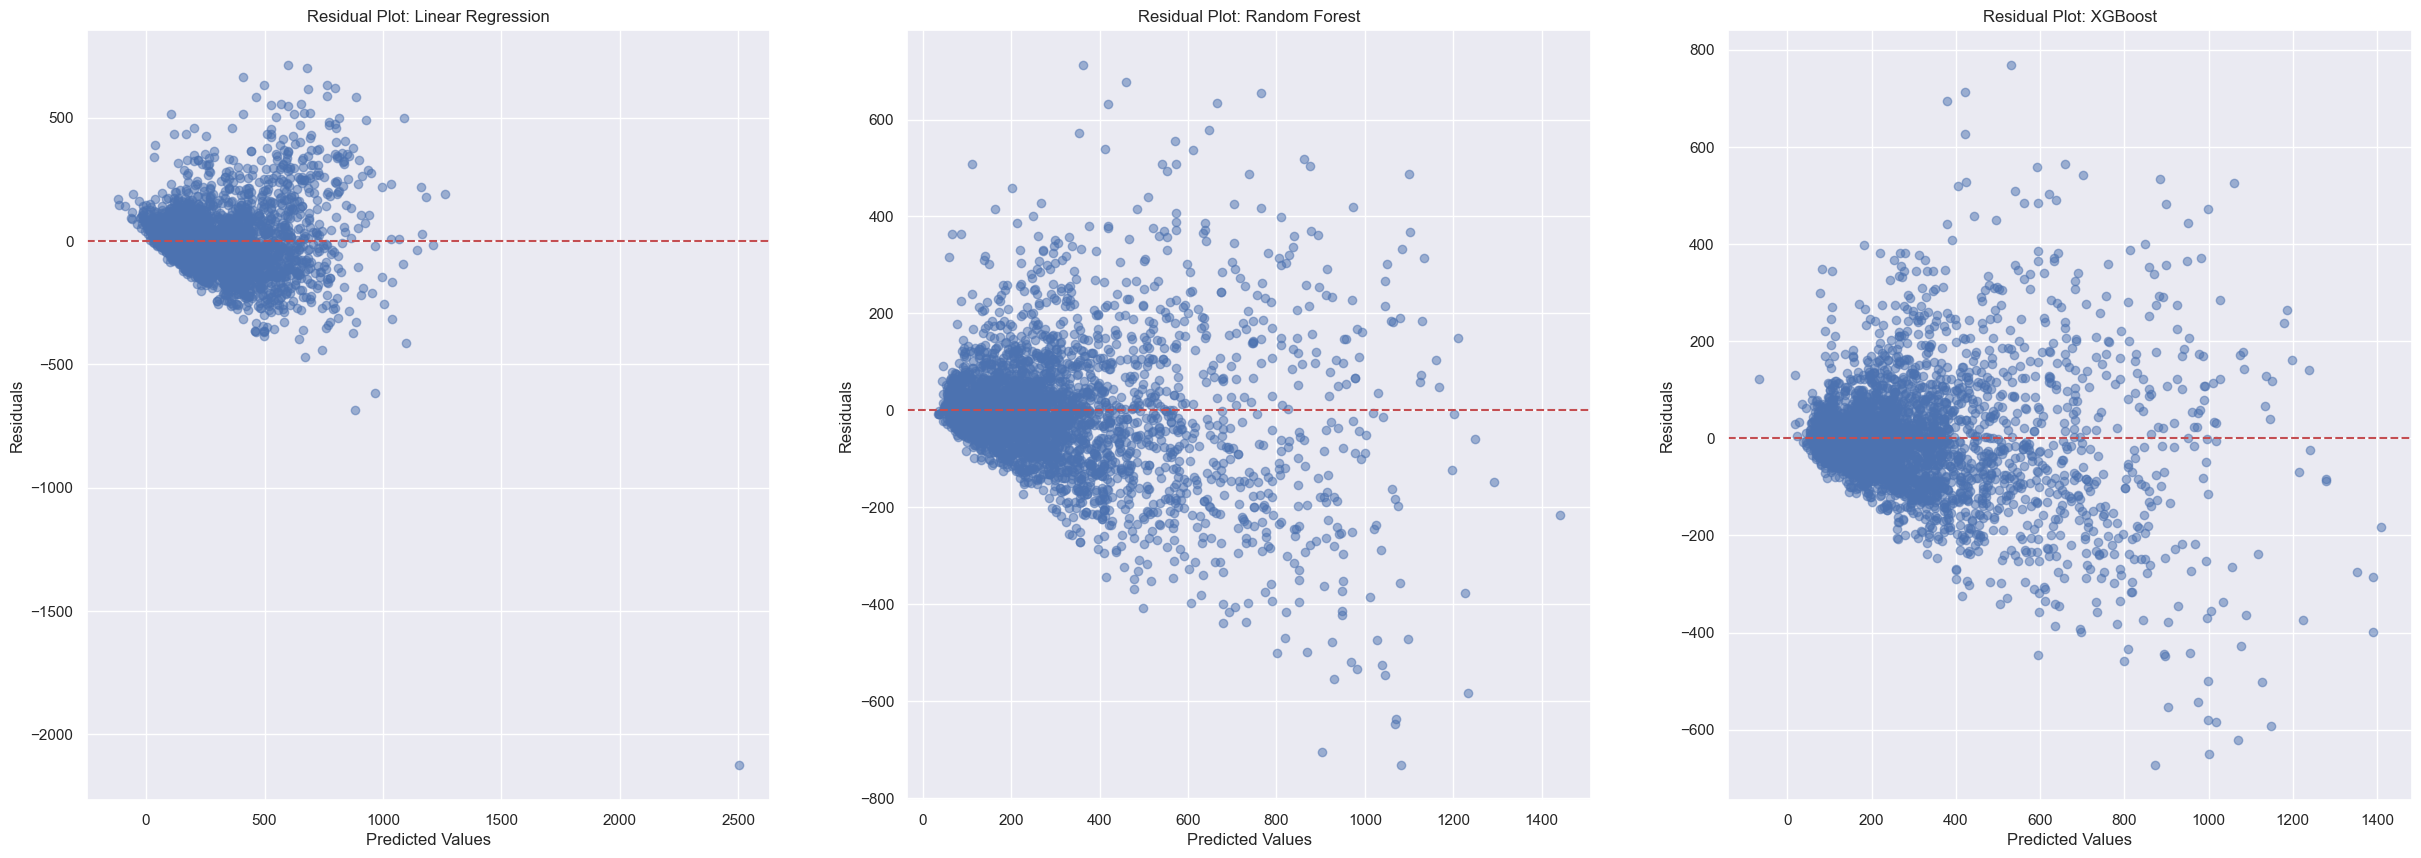

In [19]:
predictors = ['room_type', 'accommodates', 'bathrooms', 'bedrooms', 'number_of_reviews', 'neighbourhood_median_nightly']
regression_models(predictors)

Predictors:  ['host_listings_count', 'zipcode', 'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'guests_included', 'number_of_reviews']
Number of rows:  11287

Linear Regression
R-squared: 0.6485899612692565
Adjusted R-squared: 0.6477577290875377
RMSE: 138.7848888798691

Cross Validation Scores: [0.63907438 0.66945896 0.64413515 0.63674881 0.64501116]
Cross Validation Score Mean: 0.6468856929673474
Cross Validation Score Standard deviation: 0.011699613920384702

Random Forest
R-squared: 0.7642546082118364
Adjusted R-squared: 0.7636963005936288
RMSE: 113.67283886098151

Cross Validation Scores: [0.75839474 0.77165385 0.76793508 0.78776121 0.76689431]
Cross Validation Score Mean: 0.7705278379719809
Cross Validation Score Standard deviation: 0.009647735294231137

XG Boost
R-squared: 0.7794151356823913
Adjusted R-squared: 0.7788927322144988
RMSE: 109.957018369709

Cross Validation Scores: [0.77595385 0.80021412 0.78301219 0.78776713 0.78319969]
Cross Validation Score Mean: 0.78602939

<Figure size 640x480 with 0 Axes>

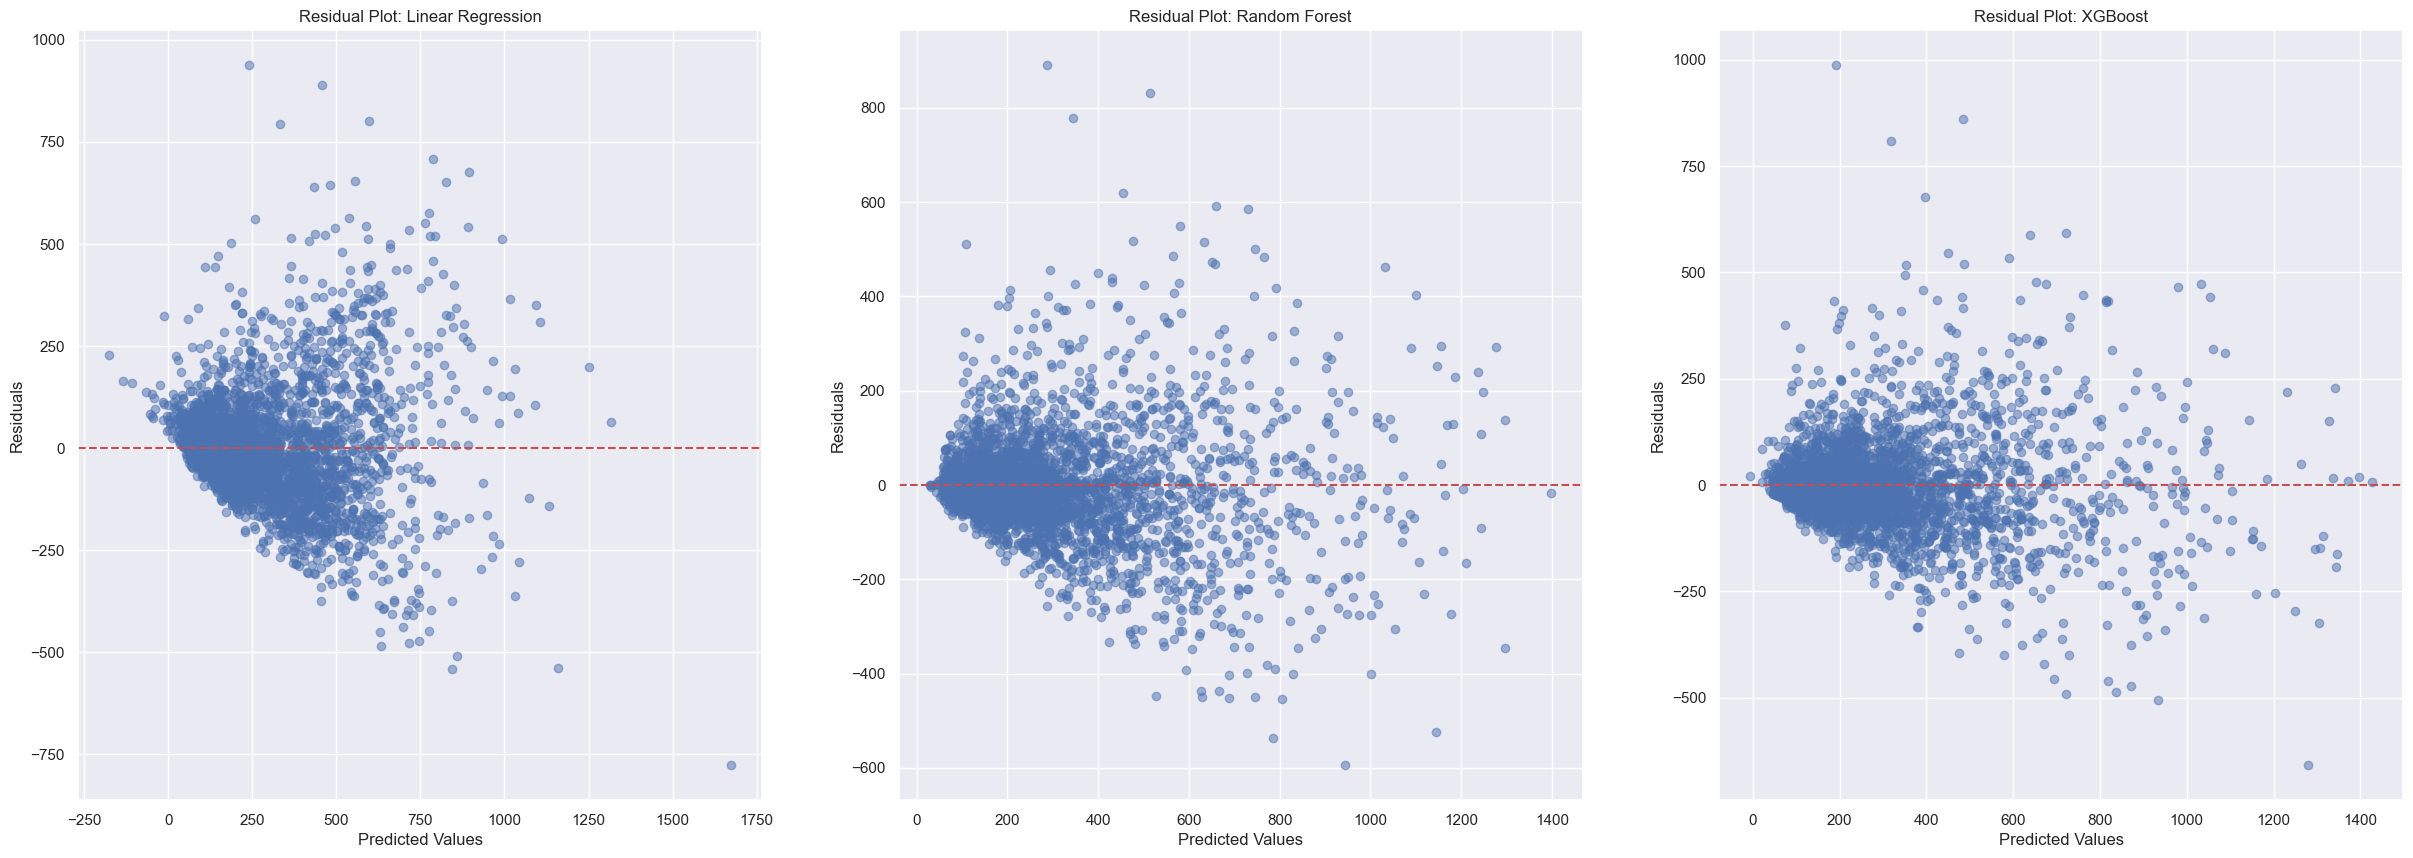

In [20]:
predictors = ['host_listings_count', 'zipcode', 'room_type', 'accommodates', 'bathrooms',
              'bedrooms', 'guests_included', 'number_of_reviews']
regression_models(predictors)

Predictors:  ['host_listings_count', 'zipcode', 'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'guests_included', 'number_of_reviews', 'cancellation_policy', 'Laptop friendly workspace', 'Cable TV', 'Beachfront']
Number of rows:  11287

Linear Regression
R-squared: 0.6863089155752998
Adjusted R-squared: 0.6851932389264864
RMSE: 131.12520732856518

Cross Validation Scores: [0.67656899 0.71069824 0.69246633 0.67723318 0.68623214]
Cross Validation Score Mean: 0.6886397773502818
Cross Validation Score Standard deviation: 0.012512626688485221

Random Forest
R-squared: 0.7766872201283216
Adjusted R-squared: 0.775892983803941
RMSE: 110.63483411721322

Cross Validation Scores: [0.76746545 0.79365133 0.78402912 0.79448523 0.77680954]
Cross Validation Score Mean: 0.7832881323717213
Cross Validation Score Standard deviation: 0.010253284863306166

XG Boost
R-squared: 0.7822095775403526
Adjusted R-squared: 0.7814349820840646
RMSE: 109.25831255950455

Cross Validation Scores: [0.78401082 0.81

<Figure size 640x480 with 0 Axes>

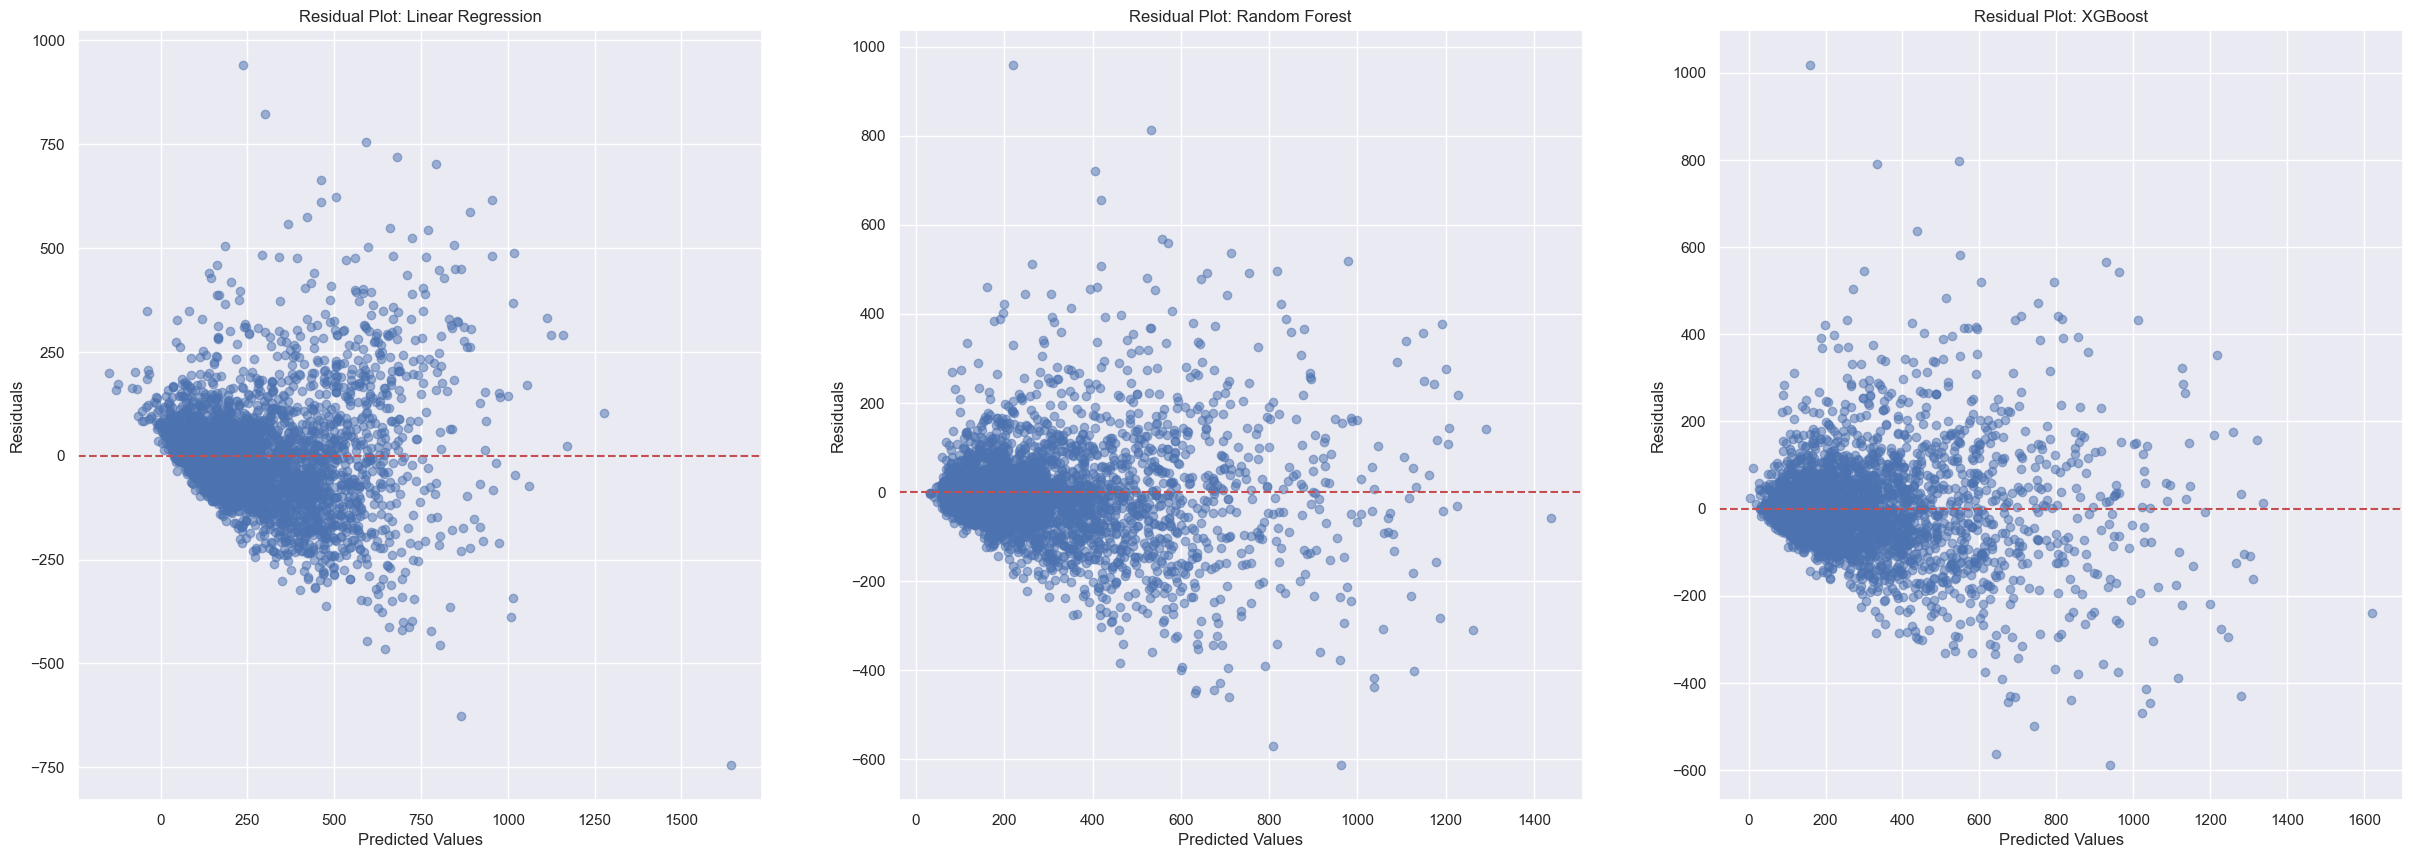

In [21]:
predictors = ['host_listings_count', 'zipcode', 'room_type', 'accommodates', 'bathrooms',
              'bedrooms', 'guests_included', 'number_of_reviews', 'cancellation_policy',
              'Laptop friendly workspace', 'Cable TV', 'Beachfront']
regression_models(predictors)

Predictors:  ['host_listings_count', 'neighbourhood_cleansed', 'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'guests_included', 'number_of_reviews', 'cancellation_policy', 'Laptop friendly workspace', 'Cable TV', 'Beachfront']
Number of rows:  11287

Linear Regression
R-squared: 0.6845085813445035
Adjusted R-squared: 0.6833865016101035
RMSE: 131.50094554315572

Cross Validation Scores: [0.6758554  0.70779669 0.68950444 0.6745846  0.68413107]
Cross Validation Score Mean: 0.6863744397799565
Cross Validation Score Standard deviation: 0.01202823868089929

Random Forest
R-squared: 0.7674155946706204
Adjusted R-squared: 0.7665883827963014
RMSE: 112.90817720040324

Cross Validation Scores: [0.76075258 0.78894275 0.77354262 0.78372302 0.77402282]
Cross Validation Score Mean: 0.7761967588925112
Cross Validation Score Standard deviation: 0.009689150094696163

XG Boost
R-squared: 0.7916837850861914
Adjusted R-squared: 0.7909428856851939
RMSE: 106.85544026709586

Cross Validation Scores: [

<Figure size 640x480 with 0 Axes>

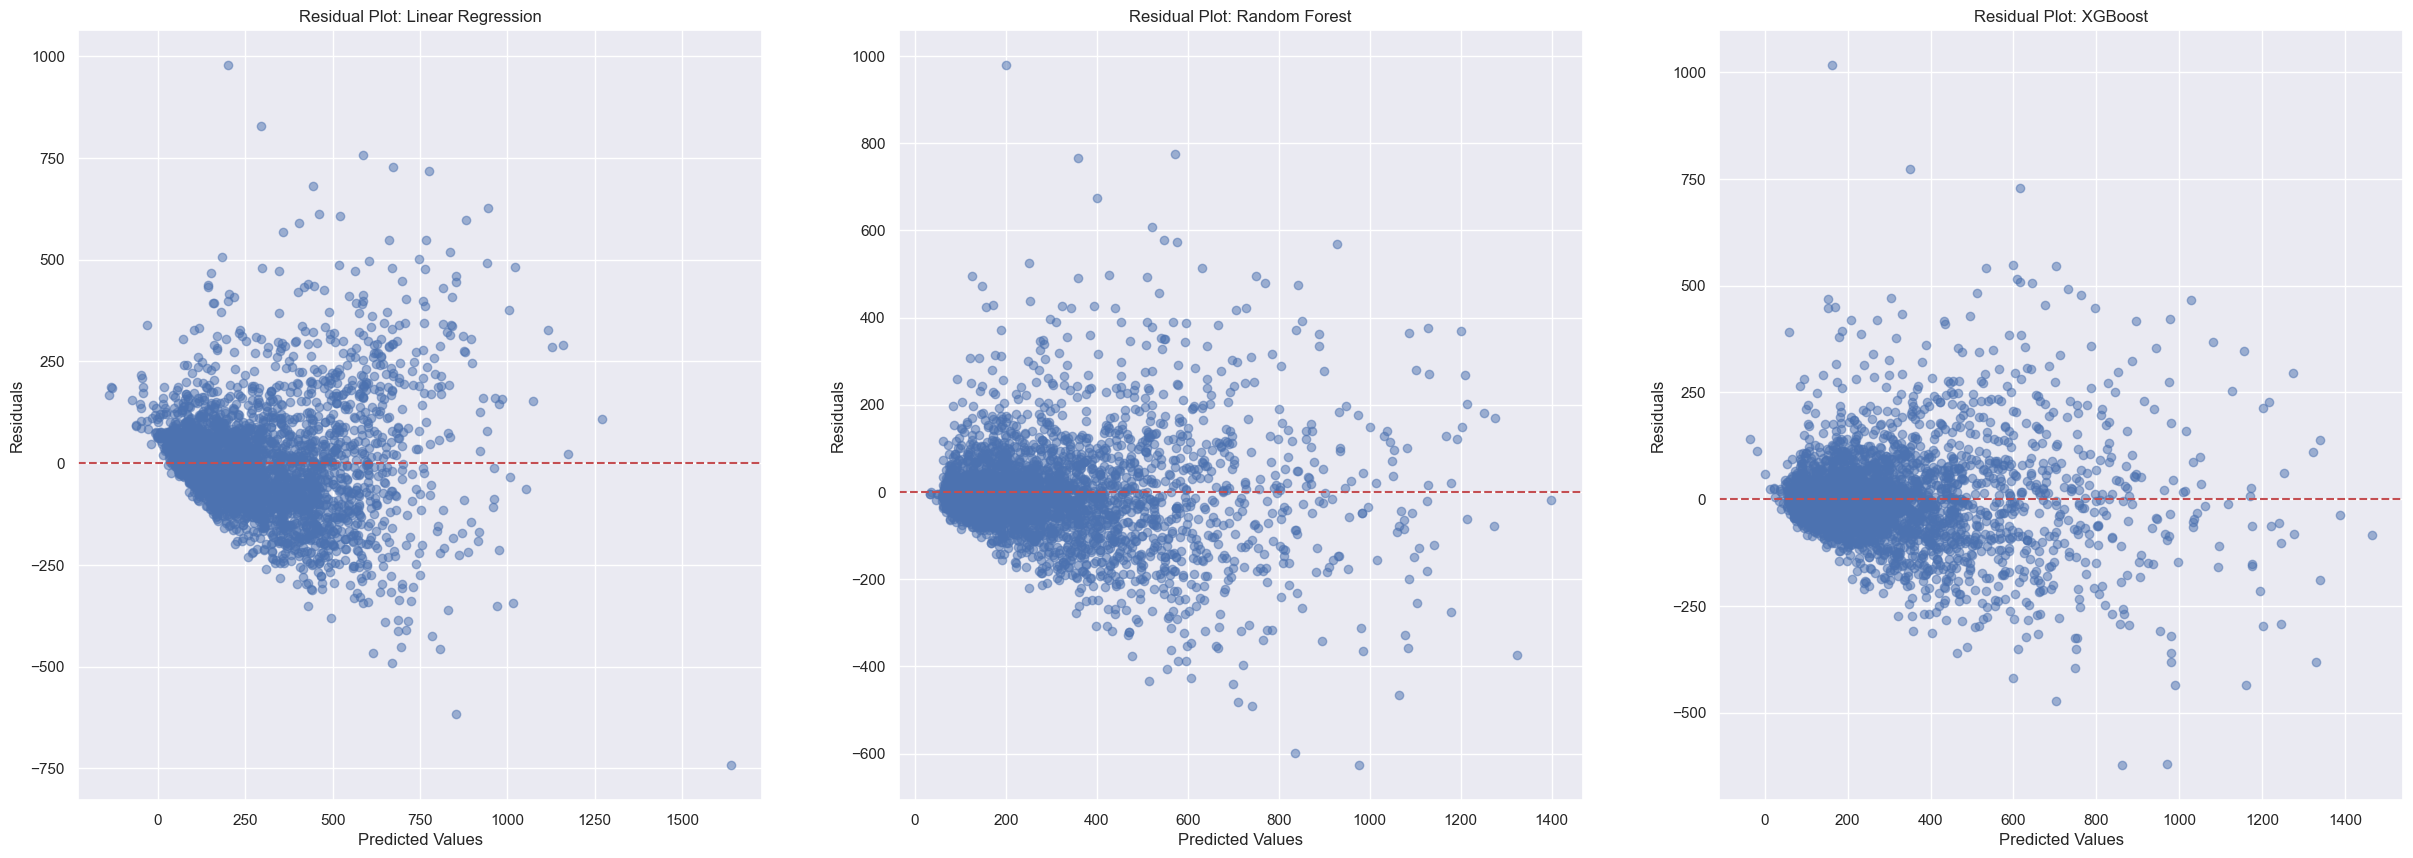

In [22]:
predictors = ['host_listings_count', 'neighbourhood_cleansed', 'room_type', 'accommodates',
              'bathrooms', 'bedrooms', 'guests_included', 'number_of_reviews',
              'cancellation_policy', 'Laptop friendly workspace', 'Cable TV', 'Beachfront']
regression_models(predictors)

In [23]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(X):
    # Create a DataFrame to store the results
    vif_data = pd.DataFrame()
    vif_data["Feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_data

# Assuming X is your feature matrix (without the intercept term)
# Example usage:
vif_scores = calculate_vif(labeled_df.dropna(subset=predictors)[predictors])
print(vif_scores)

                      Feature        VIF
0         host_listings_count   1.165859
1      neighbourhood_cleansed   4.131325
2                   room_type   1.452172
3                accommodates  13.078029
4                   bathrooms   9.366993
5                    bedrooms  11.703017
6             guests_included   3.164934
7           number_of_reviews   1.464913
8         cancellation_policy   3.477440
9   Laptop friendly workspace   3.335370
10                   Cable TV   1.917656
11                 Beachfront   1.067290
